In [10]:
import yfinance as yf
import pandas as pd

# 코스피 지수 데이터 다운로드
kospi = yf.download('^KS11', start='2020-01-01', end='2024-12-03')

# 종가만 사용
kospi = kospi[['Close']].copy()
kospi.rename(columns={'Close': 'KOSPI'}, inplace=True)
kospi.dropna(inplace=True)
print(kospi.head())

[*********************100%%**********************]  1 of 1 completed

                  KOSPI
Date                   
2020-01-02  2175.169922
2020-01-03  2176.459961
2020-01-06  2155.070068
2020-01-07  2175.540039
2020-01-08  2151.310059


## 1. 이동평균선 전략 백테스팅

In [11]:
# 이동평균선 계산
kospi['Short_MA'] = kospi['KOSPI'].rolling(window=5).mean()  # 단기 이동평균선
kospi['Long_MA'] = kospi['KOSPI'].rolling(window=20).mean()  # 장기 이동평균선

# 매수/매도 신호 생성
kospi['Signal'] = 0
kospi.loc[kospi['Short_MA'] > kospi['Long_MA'], 'Signal'] = 1  # 매수 신호
kospi.loc[kospi['Short_MA'] <= kospi['Long_MA'], 'Signal'] = -1  # 매도 신호

In [12]:
# 초기 투자금
initial_capital = 1000000
#trading_cost = 0.001  # 0.1% 거래 비용

# 포지션 생성
kospi['Position'] = kospi['Signal'].shift()  # 매수/매도 포지션
kospi['Daily_Return'] = kospi['KOSPI'].pct_change()  # 일별 수익률

# 전략 수익 계산
kospi['Strategy_Return'] = kospi['Position'] * kospi['Daily_Return']
#kospi['Strategy_Return'] = kospi['Strategy_Return'] - trading_cost
kospi['Cumulative_Strategy'] = (1 + kospi['Strategy_Return']).cumprod() * initial_capital
kospi['Cumulative_Market'] = (1 + kospi['Daily_Return']).cumprod() * initial_capital

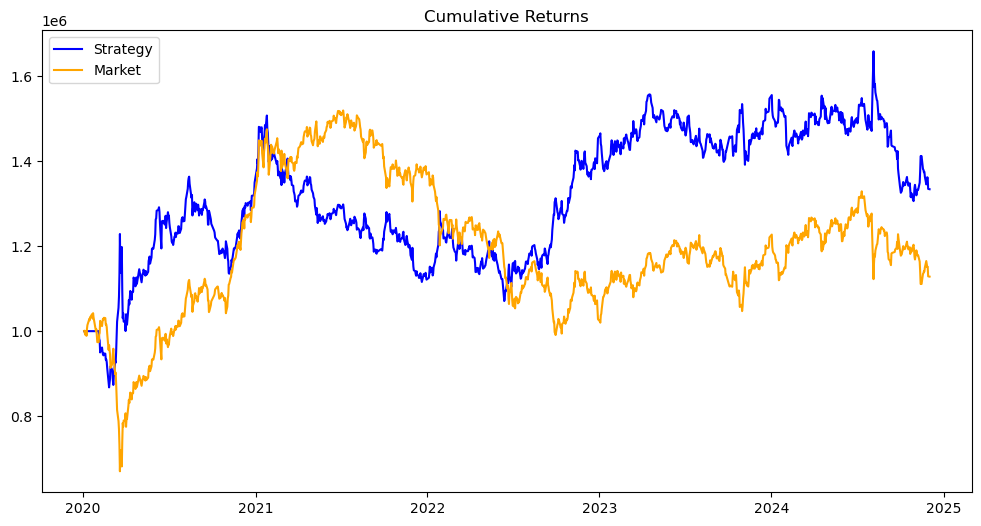

Total Strategy Return: 33.42%
Total Market Return: 12.84%


In [13]:
import matplotlib.pyplot as plt

# 누적 수익률 비교
plt.figure(figsize=(12, 6))
plt.plot(kospi['Cumulative_Strategy'], label='Strategy', color='blue')
plt.plot(kospi['Cumulative_Market'], label='Market', color='orange')
plt.title('Cumulative Returns')
plt.legend()
plt.show()

# 성과 요약
total_strategy_return = kospi['Cumulative_Strategy'].iloc[-1] / initial_capital - 1
total_market_return = kospi['Cumulative_Market'].iloc[-1] / initial_capital - 1
print(f"Total Strategy Return: {total_strategy_return:.2%}")
print(f"Total Market Return: {total_market_return:.2%}")

## 2. 볼린저밴드 백테스팅

In [20]:
import yfinance as yf
import pandas as pd

# 코스피 지수 데이터 다운로드
kospi = yf.download('^KS11', start='2020-01-01', end='2024-12-03')

# 종가만 사용
kospi = kospi[['Close']].copy()
kospi.rename(columns={'Close': 'KOSPI'}, inplace=True)
kospi.dropna(inplace=True)
print(kospi.head())


[*********************100%%**********************]  1 of 1 completed

                  KOSPI
Date                   
2020-01-02  2175.169922
2020-01-03  2176.459961
2020-01-06  2155.070068
2020-01-07  2175.540039
2020-01-08  2151.310059


In [21]:
# 이동평균선과 표준편차 계산
window = 20  # 20일 기준
kospi['MA'] = kospi['KOSPI'].rolling(window=window).mean()  # 중심선
kospi['STD'] = kospi['KOSPI'].rolling(window=window).std()  # 표준편차

# 볼린저 밴드 계산
kospi['Upper_Band'] = kospi['MA'] + (2 * kospi['STD'])  # 상단 밴드
kospi['Lower_Band'] = kospi['MA'] - (2 * kospi['STD'])  # 하단 밴드

# 볼린저 밴드 계산 완료
kospi.dropna(inplace=True)

In [22]:
# 매수 신호: 하단 밴드를 밑돌고, 다음 날 다시 상향 돌파 시
kospi['Buy_Signal'] = (kospi['KOSPI'] < kospi['Lower_Band']) & (kospi['KOSPI'].shift(1) >= kospi['Lower_Band'])

# 매도 신호: 상단 밴드를 돌파하고, 다음 날 다시 하향 돌파 시
kospi['Sell_Signal'] = (kospi['KOSPI'] > kospi['Upper_Band']) & (kospi['KOSPI'].shift(1) <= kospi['Upper_Band'])

In [23]:
# 초기 자본금 설정
initial_capital = 1000000

# 포지션 생성: 매수는 1, 매도는 0
kospi['Position'] = 0
kospi.loc[kospi['Buy_Signal'], 'Position'] = 1  # 매수
kospi.loc[kospi['Sell_Signal'], 'Position'] = 0  # 매도

# 포지션을 유지 (누적 상태로 표현)
kospi['Position'] = kospi['Position'].ffill().fillna(0)

# 일별 수익률 계산
kospi['Daily_Return'] = kospi['KOSPI'].pct_change()
kospi['Strategy_Return'] = kospi['Position'] * kospi['Daily_Return']

# 누적 수익률 계산
kospi['Cumulative_Strategy'] = (1 + kospi['Strategy_Return']).cumprod() * initial_capital
kospi['Cumulative_Market'] = (1 + kospi['Daily_Return']).cumprod() * initial_capital

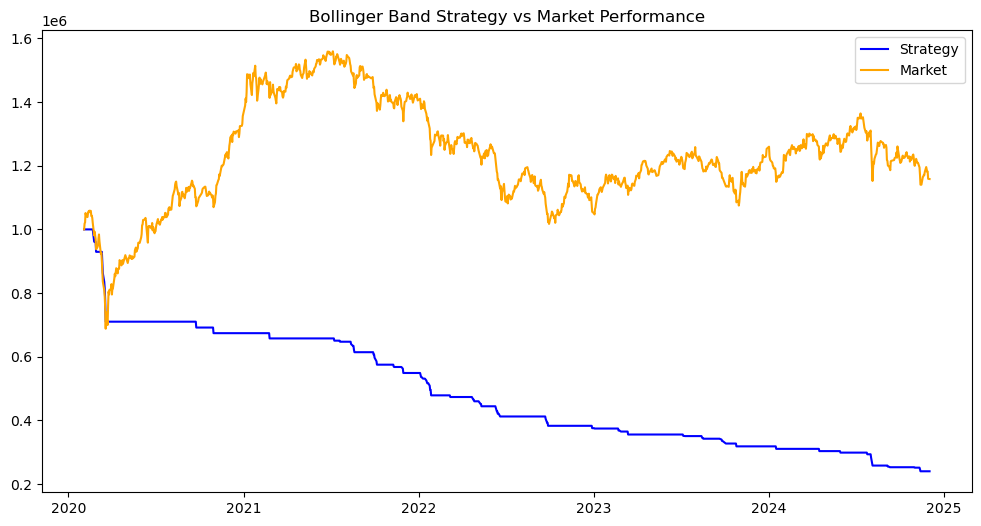

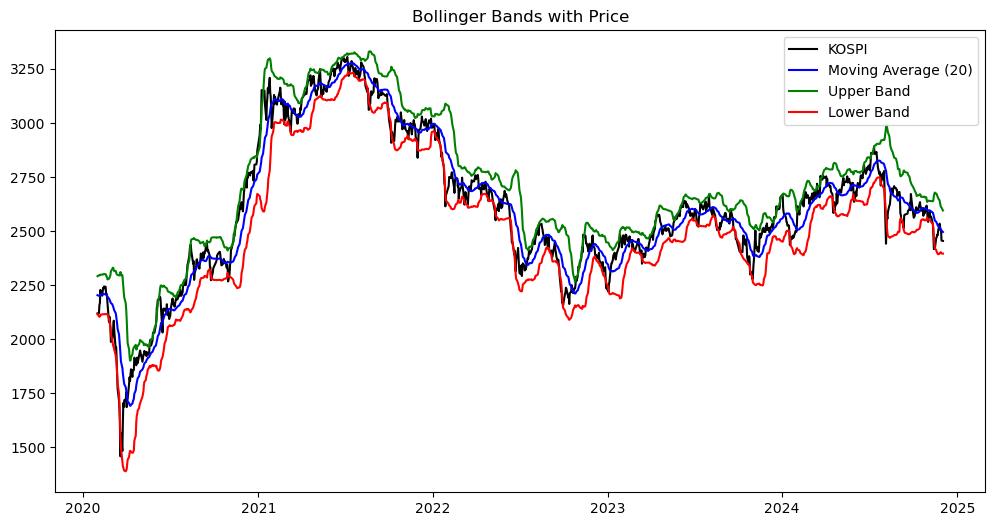

Total Strategy Return: -76.01%
Total Market Return: 15.83%


In [24]:
import matplotlib.pyplot as plt

# 누적 수익률 시각화
plt.figure(figsize=(12, 6))
plt.plot(kospi['Cumulative_Strategy'], label='Strategy', color='blue')
plt.plot(kospi['Cumulative_Market'], label='Market', color='orange')
plt.title('Bollinger Band Strategy vs Market Performance')
plt.legend()
plt.show()

# 볼린저 밴드와 가격 시각화
plt.figure(figsize=(12, 6))
plt.plot(kospi['KOSPI'], label='KOSPI', color='black')
plt.plot(kospi['MA'], label='Moving Average (20)', color='blue')
plt.plot(kospi['Upper_Band'], label='Upper Band', color='green')
plt.plot(kospi['Lower_Band'], label='Lower Band', color='red')
plt.title('Bollinger Bands with Price')
plt.legend()
plt.show()

# 성과 요약
total_strategy_return = kospi['Cumulative_Strategy'].iloc[-1] / initial_capital - 1
total_market_return = kospi['Cumulative_Market'].iloc[-1] / initial_capital - 1
print(f"Total Strategy Return: {total_strategy_return:.2%}")
print(f"Total Market Return: {total_market_return:.2%}")

## 3. 절대모멘텀 백테스팅

[*********************100%%**********************]  1 of 1 completed


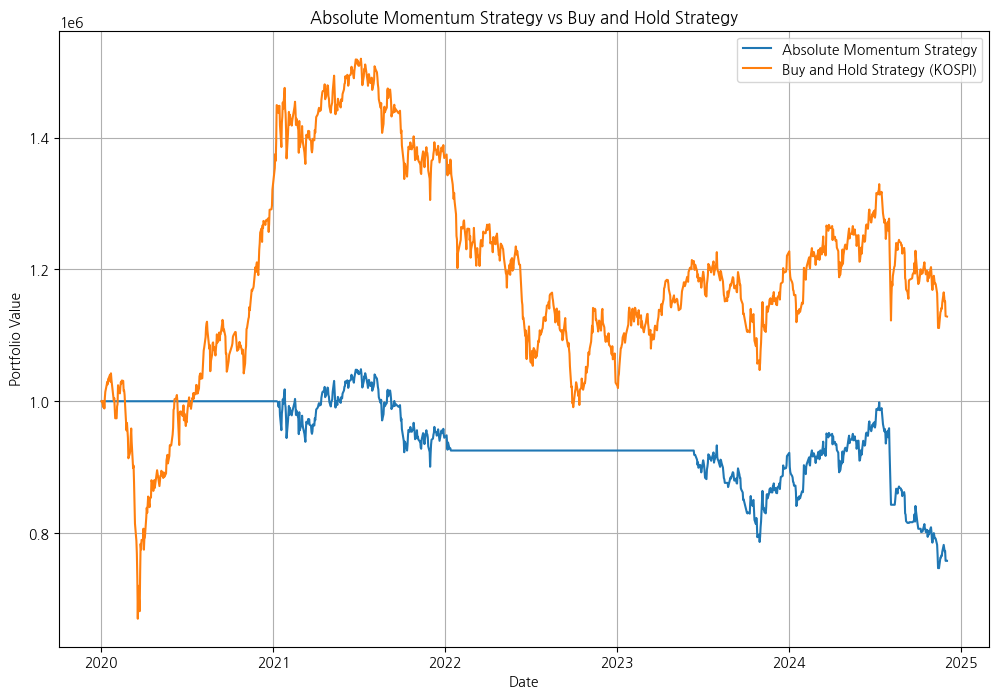

In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 코스피 지수 데이터 다운로드
kospi = yf.download('^KS11', start='2020-01-01', end='2024-12-03')['Adj Close']

# 절대 모멘텀 계산 (최근 12개월 수익률)
momentum_period = 252  # 12개월 (거래일 기준)
momentum = kospi.pct_change(periods=momentum_period)

# 투자 신호 생성
signal = (momentum > 0).astype(int)

# 투자 전략 백테스트
initial_investment = 1000000  # 초기 투자금
portfolio = pd.DataFrame(index=kospi.index)
portfolio['KOSPI'] = kospi
portfolio['Signal'] = signal.shift(1).fillna(0)
portfolio['Holdings'] = initial_investment * (1 + portfolio['Signal'] * kospi.pct_change().fillna(0)).cumprod()

# 결과 시각화
plt.figure(figsize=(12, 8))
plt.plot(portfolio['Holdings'], label='Absolute Momentum Strategy')
plt.plot(initial_investment * (1 + kospi.pct_change().fillna(0)).cumprod(), label='Buy and Hold Strategy (KOSPI)')
plt.legend()
plt.title('Absolute Momentum Strategy vs Buy and Hold Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

## 4. 듀얼모멘텀 전략 백테스팅

[*********************100%%**********************]  2 of 2 completed
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_7456\3867995506.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.04154363  0.01378897  0.01191587  0.01794843  0.01146694  0.02653102
 -0.03087211 -0.01106136 -0.04200381 -0.03159411 -0.03651777  0.06566124
  0.00029415  0.0145568  -0.02521743 -0.02126085 -0.06398274  0.10684041
  0.06812826]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  momentum.loc[momentum['Position'] == 1, 'Strategy_Return'] = monthly_data['Return_자산1']


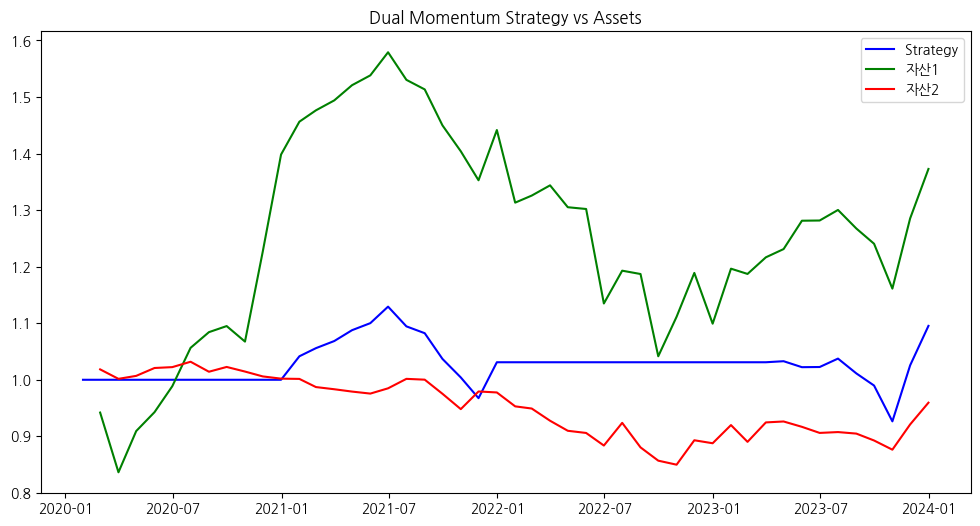

Total Strategy Return: 9.53%
Total 자산1 Return: 37.28%
Total 자산2 Return: -4.05%


In [51]:
import yfinance as yf
import pandas as pd

# 데이터 다운로드
#assets = ['SPY', 'TLT']  # SPY: 주식, TLT: 채권
assets = ['102110.KS', '148070.KS']  # TIGER 200: 102110.KQ, KOSEF 국고채10년: 148070.KQ
data = yf.download(assets, start='2020-01-01', end='2023-12-31')['Adj Close']

# 월별 데이터로 리샘플
monthly_data = data.resample('M').last()

# 열 이름 변경
monthly_data.columns = ['자산1', '자산2']

# 12개월 수익률 계산
momentum = monthly_data.pct_change(12)

# 상대적 모멘텀: 자산1와 자산2 중 강한 자산 선택
momentum['Relative'] = momentum['자산1'] > momentum['자산2']

# 절대적 모멘텀: 선택된 자산이 0보다 큰지 확인
momentum['Absolute'] = momentum[['자산1', '자산2']].max(axis=1) > 0

# 투자 자산 결정
momentum['Position'] = 0
momentum.loc[momentum['Relative'] & momentum['Absolute'], 'Position'] = \
    momentum.loc[momentum['Relative'], '자산1'].notnull().astype(int)

# 안전자산으로 이동
momentum.loc[~momentum['Absolute'], 'Position'] = -1

# 전략 수익률 계산
monthly_data['Return_자산1'] = monthly_data['자산1'].pct_change()
monthly_data['Return_자산2'] = monthly_data['자산2'].pct_change()

# 투자에 따른 수익률
momentum['Strategy_Return'] = 0
momentum.loc[momentum['Position'] == 1, 'Strategy_Return'] = monthly_data['Return_자산1']
momentum.loc[momentum['Position'] == 0, 'Strategy_Return'] = monthly_data['Return_자산2']
momentum.loc[momentum['Position'] == -1, 'Strategy_Return'] = 0  # 안전자산은 0% 수익 가정

# 누적 수익률
momentum['Cumulative_Strategy'] = (1 + momentum['Strategy_Return']).cumprod()
momentum['Cumulative_자산1'] = (1 + monthly_data['Return_자산1']).cumprod()
momentum['Cumulative_자산2'] = (1 + monthly_data['Return_자산2']).cumprod()

import matplotlib.pyplot as plt

# 한글깨짐해결
plt.rc('font', family='NanumGothic')

# 누적 수익률 비교
plt.figure(figsize=(12, 6))
plt.plot(momentum['Cumulative_Strategy'], label='Strategy', color='blue')
plt.plot(momentum['Cumulative_자산1'], label='자산1', color='green')
plt.plot(momentum['Cumulative_자산2'], label='자산2', color='red')
plt.title('Dual Momentum Strategy vs Assets')
plt.legend()
plt.show()

strategy_return = momentum['Cumulative_Strategy'].iloc[-1] - 1
자산1_return = momentum['Cumulative_자산1'].iloc[-1] - 1
자산2_return = momentum['Cumulative_자산2'].iloc[-1] - 1

print(f"Total Strategy Return: {strategy_return:.2%}")
print(f"Total 자산1 Return: {자산1_return:.2%}")
print(f"Total 자산2 Return: {자산2_return:.2%}")

trading_cost = 0.001  # 0.1% 거래 비용
momentum['Strategy_Return'] -= trading_cost * (momentum['Position'].diff().abs())

momentum.to_csv('백테스팅_듀얼모멘텀.csv', encoding="utf-8-sig")

In [49]:
print(momentum)

                 자산1       자산2  Relative  Absolute  Position  Strategy_Return  \
Date                                                                            
2009-04-30       NaN       NaN     False     False        -1              NaN   
2009-05-31       NaN       NaN     False     False        -1         0.000000   
2009-06-30       NaN       NaN     False     False        -1         0.000000   
2009-07-31       NaN       NaN     False     False        -1         0.000000   
2009-08-31       NaN       NaN     False     False        -1         0.000000   
...              ...       ...       ...       ...       ...              ...   
2023-08-31  0.067803  0.027710      True      True         1        -0.025218   
2023-09-30  0.191049  0.041629      True      True         1        -0.021261   
2023-10-31  0.044759  0.031228      True      True         1        -0.063983   
2023-11-30  0.080985  0.031319      True      True         1         0.106840   
2023-12-31  0.248918  0.0808